In [6]:
import glob
from pathlib import Path

import numpy as np

import matplotlib
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.constants as astcont
import astropy.units as u
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import pysynphot

from astropy.visualization import quantity_support

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
def load_sky_spectrum(fitsfile, pixscale=0.6, slitwidth=5., zeropoint=48.6):
    """
    Load a Pypeit-reduced 1D sky spectrum and return wavelength in Angstroms and flux in ABmag/arcsec**2

        fitsfile: string - filename of FITS spectrum
        pixscale: float - spatial pixel scale (arcsec/pixel)
        slitwidth: float - width of the slit (arcsec)
        zeropoint: float - zeropoint for AB mag system (AB mag)
    """
    spec = Table.read(fitsfile)
    # we get the calibration function from the ratio of FLAM to COUNTS
    sensfunc = spec['OPT_FLAM'] / spec['OPT_COUNTS']
    # we use the boxcar sky counts to make the extraction pixel area more deterministic
    flux = 1e-17 * sensfunc * spec['BOX_COUNTS_SKY'] / (spec['BOX_NPIX'] * slitwidth * pixscale)  # flam/arcsec**2
    wave = spec['OPT_WAVE']
    spec = pysynphot.ArraySpectrum(wave, flux, fluxunits='flam')
    return spec

In [8]:
sky1 = Table.read("../Sky1.txt", format='ascii', names=['wave', 'abmag'])
sky2 = Table.read("../Sky2.txt", format='ascii', names=['wave', 'abmag'])
massey_blue = pysynphot.ArraySpectrum(sky1['wave'], sky1['abmag'], fluxunits='abmag')
massey_red = pysynphot.ArraySpectrum(sky2['wave'], sky2['abmag'], fluxunits='abmag')

In [9]:
features = Table.read("features.csv")

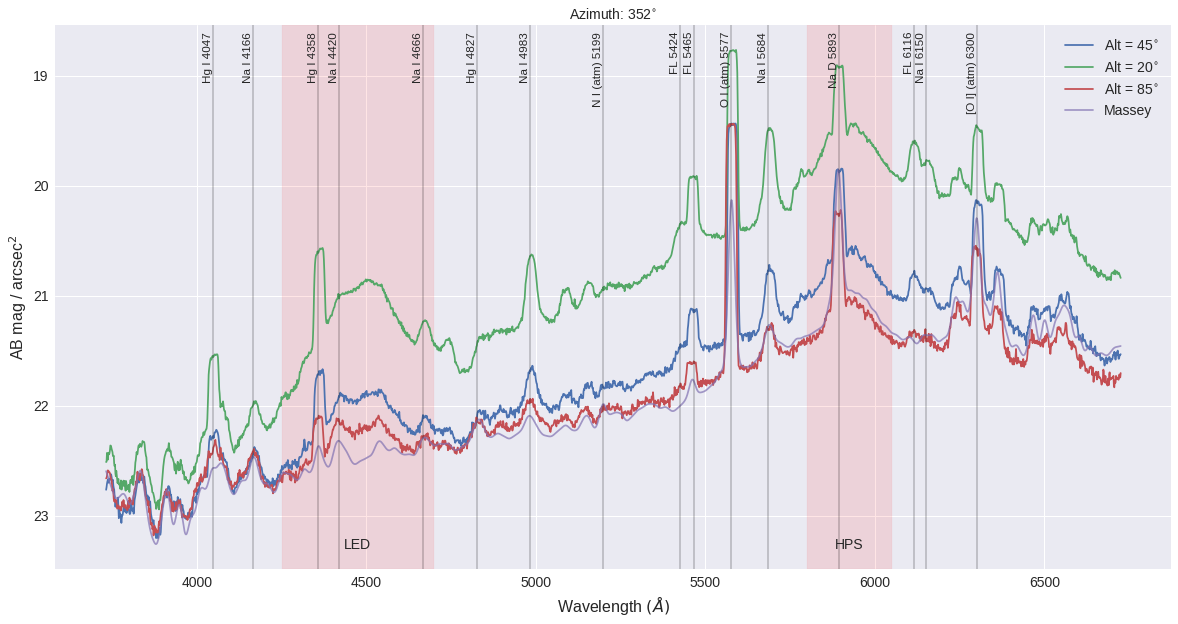

In [14]:
plt.figure(figsize=[20,10])
tus_el45 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0036-sky_az352_el45_Blue_Channel_2019Oct06T091809.000.fits")
tus_el20 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0031-sky_az352_el20_Blue_Channel_2019Oct06T090420.000.fits")
zen = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0008-sky_az270_el85_Blue_Channel_2019Oct06T080122.000.fits")
#zen = load_sky_spectrum("20190607_ggw/pypeit/Science/spec1d_skyobs0007-sky_az90_el85_Blue_Channel_2019Jun07T081307.000.fits")
tus_el45.convert('abmag')
tus_el20.convert('abmag')
zen.convert('abmag')
w = massey_blue.wave
tus_el45_flux = tus_el45.sample(w)
tus_el20_flux = tus_el20.sample(w)
zen_flux = zen.sample(w)
txt_y = 18.6
kernel = Gaussian1DKernel(7)
massey_smooth = convolve(massey_blue.flux.data, kernel, nan_treatment='fill', boundary='extend')
plt.plot(w, tus_el45_flux, label="Alt = 45$^{\circ}$")
plt.plot(w, tus_el20_flux, label="Alt = 20$^{\circ}$")
plt.plot(w, zen_flux, label="Alt = 85$^{\circ}$")
plt.plot(w, massey_smooth, alpha=0.7, label="Massey")
#plt.plot(massey_red.wave, massey_red.flux, alpha=0.3, label="Massey Red")
plt.gca().invert_yaxis()
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("AB mag / arcsec$^2$")
plt.title("Azimuth: 352$^{\circ}$")
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, 23.2, f['name'], horizontalalignment='center', verticalalignment='top')
    else:
        x = f['low wave']
        plt.text(x, txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='small', horizontalalignment='right', verticalalignment='top')
        plt.axvline(x, color='black', alpha=0.2)
plt.legend()
plt.savefig("tucson.pdf")
plt.show()

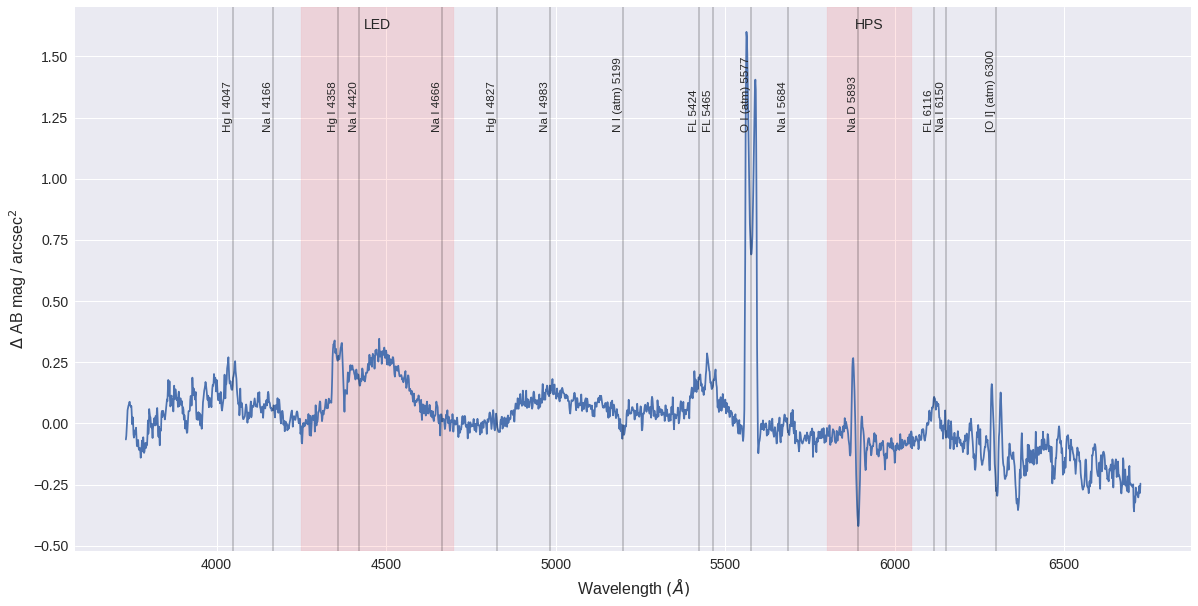

In [15]:
plt.figure(figsize=[20,10])
diff = massey_smooth-zen_flux
plt.ylabel("AB mag arcsec$^-2$")
plt.plot(w, diff)
txt_y = diff.max()
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, txt_y, f['name'], horizontalalignment='center', verticalalignment='bottom')
    else:
        x = f['low wave']
        plt.text(x, 0.75*txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='small', horizontalalignment='right')
        plt.axvline(x, color='black', alpha=0.2)
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("$\Delta$ AB mag / arcsec$^2$")
plt.savefig("zenith_diff.pdf")
plt.show()

In [16]:
june_path = Path("20190607_ggw/pypeit/Science")
oct_path = Path("20191005/pypeit/Science")

oct_files = [
    "az90_el85",
    "az270_el85",
    "az37.6_el20",
    "az37.6_el45",
    "az67.5_el20",
    "az67.5_el45",
    "az352_el20",
    "az352_el45",
    "az186.6_el20",
    "az186.6_el45",
    "az186.6_el40",
    "az270_el20",
    "az270_el47",
    "az90_el20",
    "az90_el56"
]

june_files = [
    "az90_el85",
    "az37.6_el20",
    "az37.6_el45",
    "az67.5_el20",
    "az67.5_el45",
    "az352_el20",
    "az352_el45",
    "az186.6_el20",
    "az186.6_el45",
    "az180_el20",
    "az180_el40",
    "az90_el20",
    "az90_el56",
    "az0_el20",
    "az0_el42",
    "az270_el20",
    "az270_el47"
]

In [17]:
def coadd_spectra(filelist):
    spectra = []
    for f in filelist:
        spectra.append(load_sky_spectrum(f))
    nspec = len(spectra)
    sp = spectra.pop(0)
    for s in spectra:
        sp = sp + s
    arr_sp = pysynphot.ArraySpectrum(sp.wave, sp.flux/nspec, fluxunits='flam')
    return arr_sp

In [18]:
june_spectra = {}
oct_spectra = {}
for loc in june_files:
    june_spectra[loc] = coadd_spectra(june_path.glob(f"spec1d*{loc}*.fits"))
    june_spectra[loc].convert('abmag')
for loc in oct_files:
    oct_spectra[loc] = coadd_spectra(oct_path.glob(f"spec1d*{loc}*.fits"))
    oct_spectra[loc].convert('abmag')

In [19]:
sorted(list(set(june_files).intersection(oct_files)))

['az186.6_el20',
 'az186.6_el45',
 'az270_el20',
 'az270_el47',
 'az352_el20',
 'az352_el45',
 'az37.6_el20',
 'az37.6_el45',
 'az67.5_el20',
 'az67.5_el45',
 'az90_el20',
 'az90_el56',
 'az90_el85']

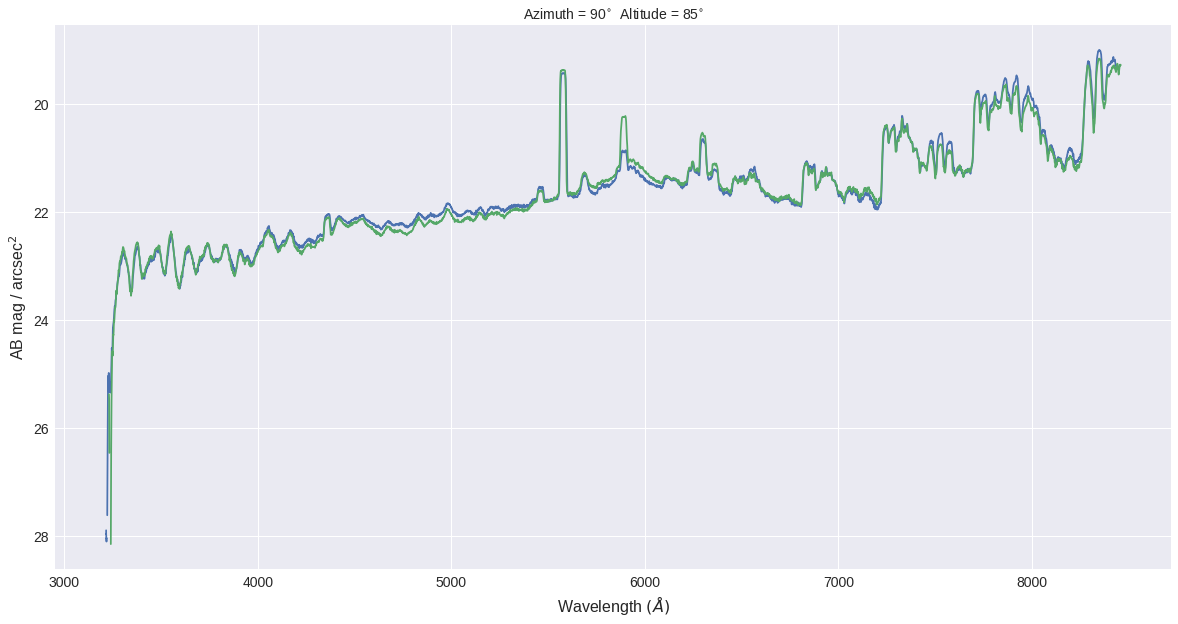

In [23]:
plt.figure(figsize=[20,10])
key = 'az90_el85'
plt.plot(june_spectra[key].wave, june_spectra[key].flux, label="June 2019")
plt.plot(oct_spectra[key].wave, oct_spectra[key].flux, label="October 2019")
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("AB mag / arcsec$^2$")
plt.title("Azimuth = 90$^{\circ}$  Altitude = 85$^{\circ}$")
plt.gca().invert_yaxis()
plt.show()